In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
import sys
from unstructured.partition.pdf import partition_pdf
import base64
from IPython.display import Image, display
from langchain_openai import ChatOpenAI # Changed from langchain_groq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


In [ ]:
print("Current Python working directory:", os.getcwd())
# find_dotenv() searches up the directory tree until it finds the .env file
load_dotenv(find_dotenv())

api_key = os.getenv("OPENAI_API_KEY")
file_path = os.getenv("ATTENTION_FILEPATH")

if not (api_key and file_path):
    raise ValueError("Environmental variables couldn't be loaded.")

else:
    print("Environmental variables loaded successfully!")


Current Python working directory: /home/ebd-marco/Documentos/Code/DocumentParsing
Environmental variables loaded successfully!


In [ ]:
chunks = partition_pdf(
    filename=file_path,                      
    infer_table_structure=True, #extract tables            
    strategy="hi_res", #mantatory to infer tables

    extract_image_block_types=["Table"],
    extract_image_block_output_type="base64",
    extract_image_block_output_dir="./images",
    extract_images_in_pdf=True,

    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
    #extract_images_in_pdf=True,
)

/home/ebd-marco/Documentos/Code/DocumentParsing/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
# set([str(type(el)) for el in chunks])

In [4]:
# chunks[3].metadata.orig_elements

In [5]:
# len(chunks) #number of elements inside the document

In [6]:
tables = []
texts = []
for chunk in chunks:
    if "Table" in str(type((chunk))):
        tables.append(chunk)
    
    if "CompositeElement" in str(type(chunk)):
        texts.append(chunk)

In [7]:
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    print("--- IMAGE ---")
                    print(f"type: {type(el)}")
                    print(f"metadata keys: {el.metadata.__dict__.keys()}")
                    print(f"image_base64: {el.metadata.image_base64 is not None}")
                    print(f"image path: {el.metadata.image_path}")
                    image_data = el.metadata.image_base64
                    if image_data is not None:
                        images_b64.append(image_data)
                        print("Image appended.")
                    else:
                        print("Image found but image_base64 is None.")

    return images_b64

images = get_images_base64(chunks)

--- IMAGE ---
type: <class 'unstructured.documents.elements.Image'>
metadata keys: dict_keys(['coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'image_path'])
image_base64: False
image path: ./images/figure-3-1.jpg
Image found but image_base64 is None.
--- IMAGE ---
type: <class 'unstructured.documents.elements.Image'>
metadata keys: dict_keys(['coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'image_path'])
image_base64: False
image path: ./images/figure-4-2.jpg
Image found but image_base64 is None.
--- IMAGE ---
type: <class 'unstructured.documents.elements.Image'>
metadata keys: dict_keys(['coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'image_path'])
image_base64: False
image path: ./images/figure-4-3.jpg
Image found but image_base64 is None.
--- IMAGE ---
type: <class 'unstructured.documents.elements.Image'>
metadata keys:

In [8]:
def get_images_base64_from_disk(image_dir="./images"):
    images_b64 = []
    for filename in os.listdir(image_dir):
        filepath = os.path.join(image_dir, filename)
        if filepath.lower().endswith((".png", ".jpg", ".jpeg")):
            with open(filepath, "rb") as img_file:
                b64 = base64.b64encode(img_file.read()).decode("utf-8")
                images_b64.append(b64)
    return images_b64

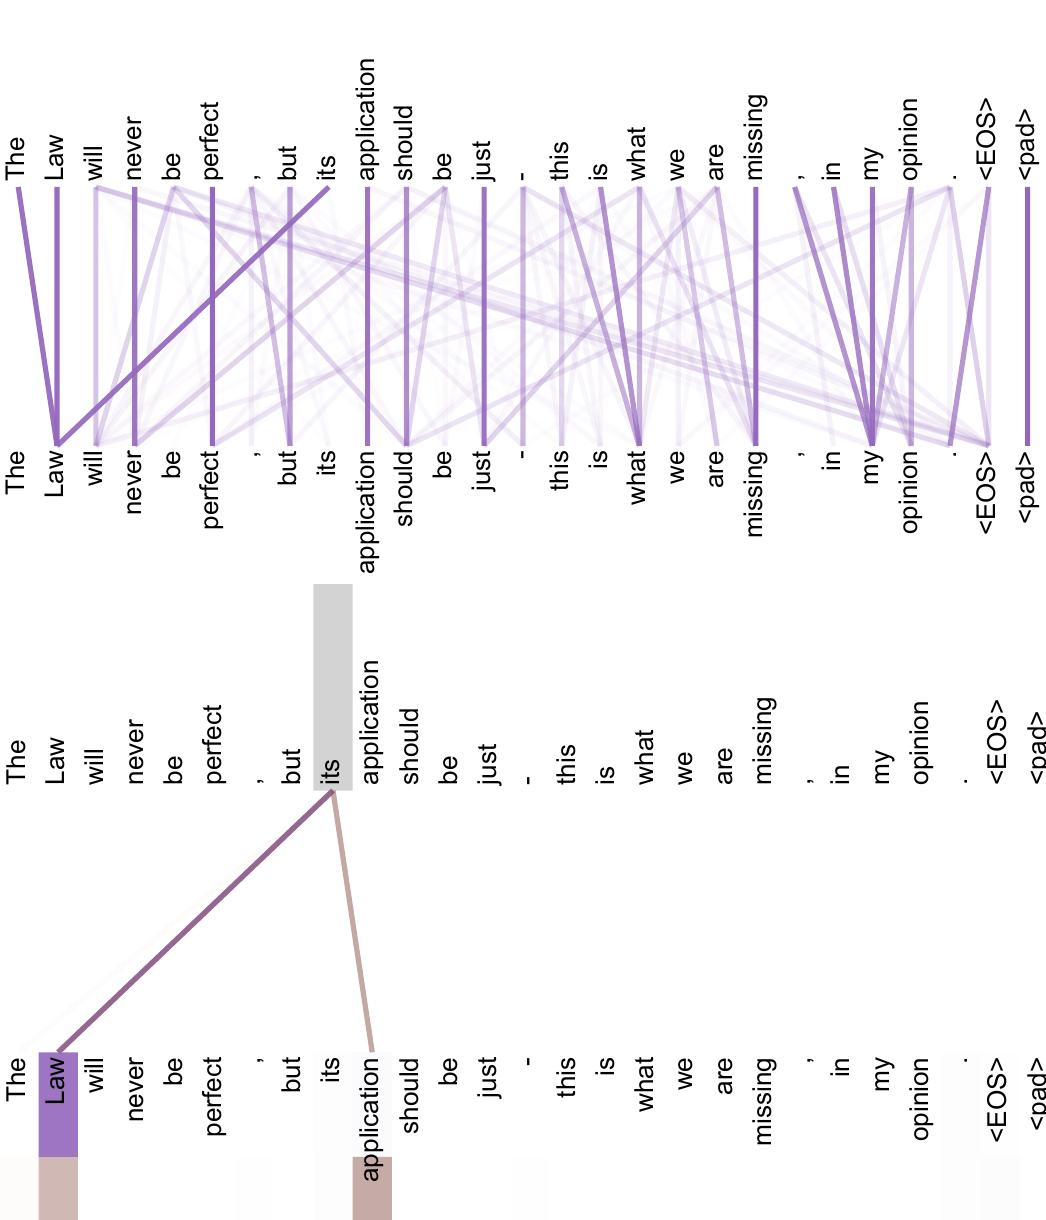

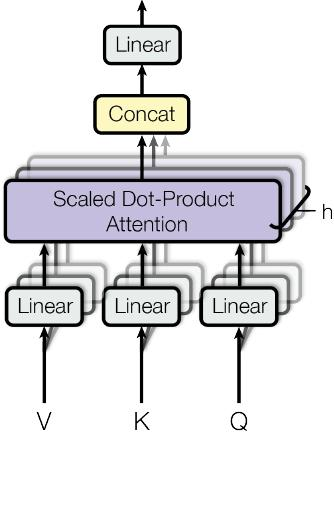

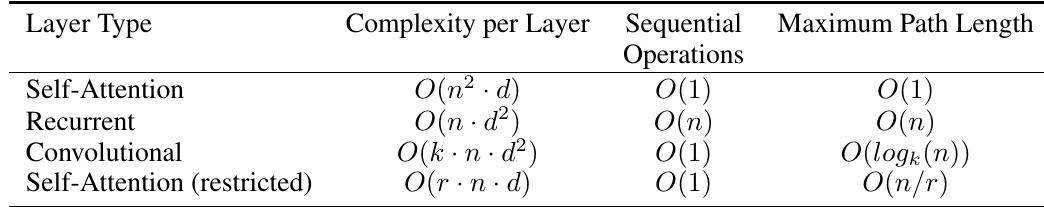

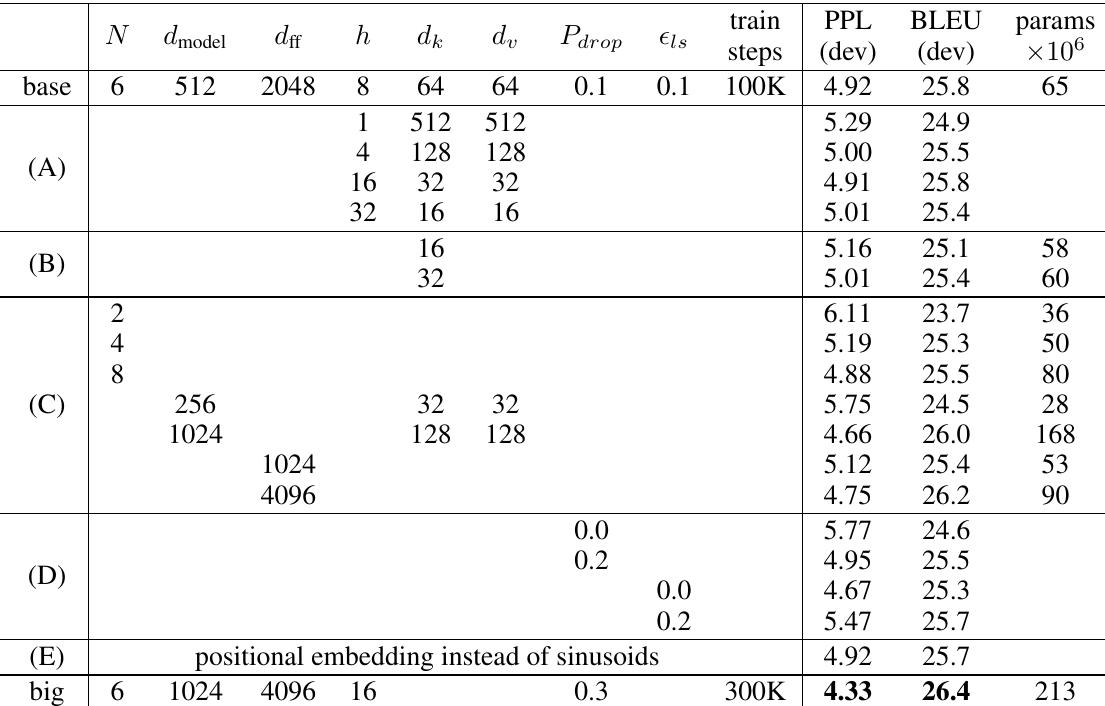

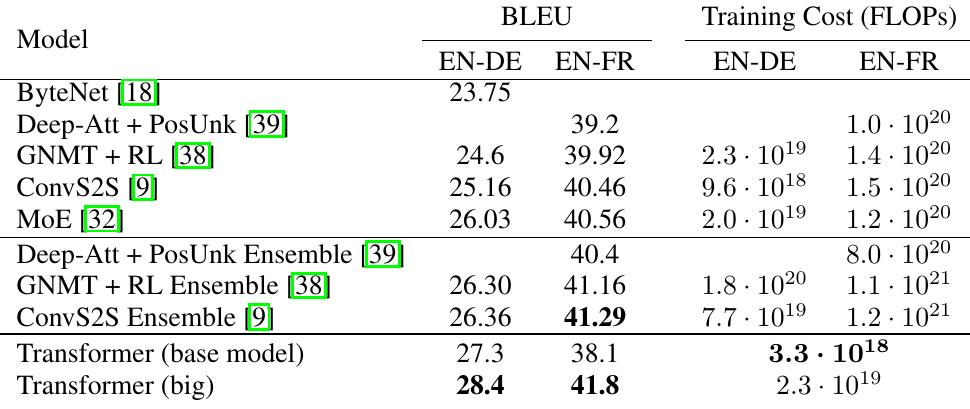

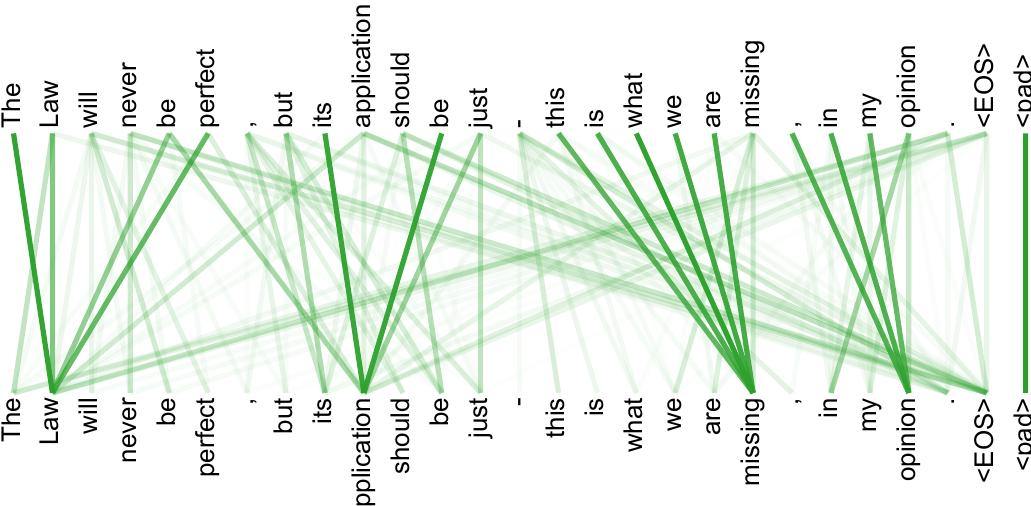

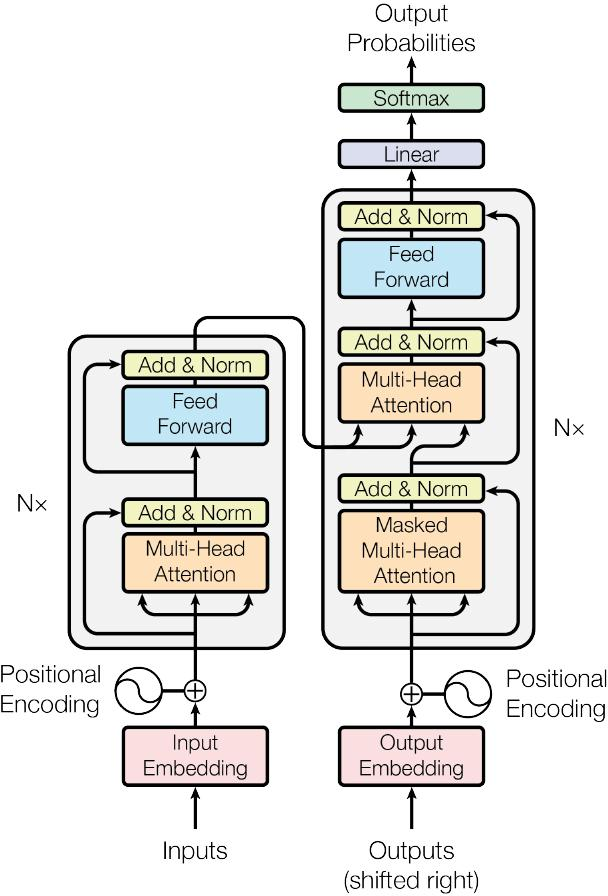

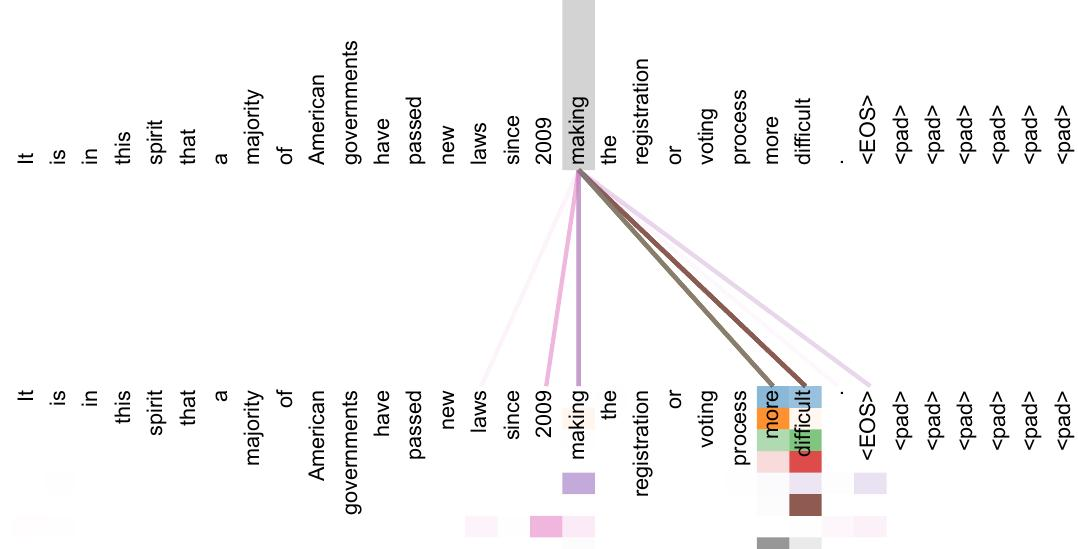

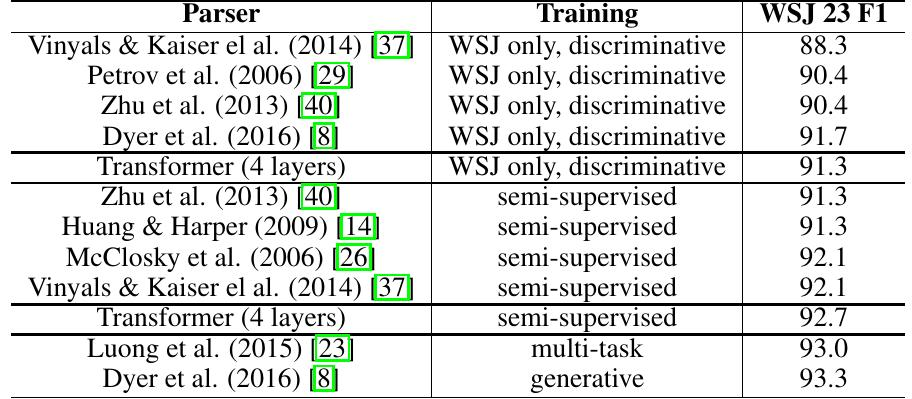

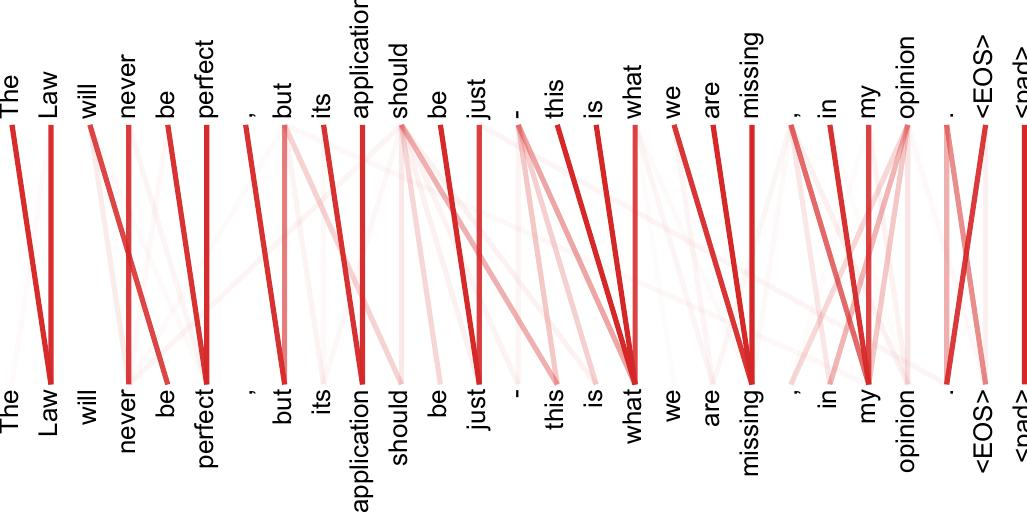

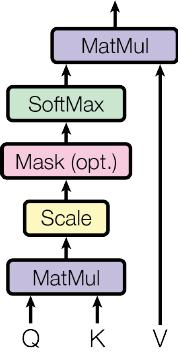

In [ ]:
def display_base64_image(base64_code):
    for image in base64_code:
        image_data = base64.b64decode(image)
        display(Image(data=image_data))

images_b64 = get_images_base64_from_disk()
display_base64_image(images_b64)

In [10]:
images_b64 = get_images_base64_from_disk()
# display_base64_image(images_b64)

In [ ]:
prompt_text = """
    You are an assistant tasked with summarizing tables and text.
    Give a concise summary of the table or text.

    Respond only with the summary, no additionnal comment.
    Do not start your message by saying "Here is a summary" or anything like that.

    Table or text chunk: {element}


"""

prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatOpenAI(temperature = 0.5, model="gpt-4o", openai_api_key="hardcoded_api_key") # Changed from langchain_groq
summarize_chain = prompt | model | StrOutputParser()

In [13]:
text_summaries = summarize_chain.batch(texts, {"max_concurrency":3})

tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency":3})

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTP

In [14]:
text_summaries

['The paper introduces the Transformer, a new network architecture based solely on attention mechanisms, eliminating the need for recurrence and convolutions. The Transformer demonstrates superior performance in machine translation tasks, achieving a BLEU score of 28.4 on the WMT 2014 English-to-German task and a state-of-the-art score of 41.8 on the English-to-French task, with significantly reduced training time. The model also generalizes well to other tasks like English constituency parsing. The paper credits multiple contributors for various aspects of the development and implementation of the Transformer model.',
 'Recurrent neural networks (RNNs), including long short-term memory (LSTM) and gated recurrent units, are widely used for sequence modeling and transduction tasks like language modeling and machine translation. These models process input and output sequences sequentially, which limits parallelization and efficiency, especially for long sequences. Attention mechanisms ha

In [15]:
table_summaries

[]

In [ ]:
prompt_template = """Describe the image in detail. For context,
                    the image is part of a research paper explaining the transformers
                    architecture. Be specific about graphs, such as bar plots."""

messages = [
    (
        "user",
        [
            {"type":"text","text":prompt_template},
            {
                "type":"image_url",
                "image_url":{"url":"data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(temperature = 0.5, model="gpt-4o", openai_api_key="hardcoded_api_key") | StrOutputParser()

image_summaries = chain.batch(images_b64) #Keep it like this to analyze the locally extracted images (no in-memory info)

In [17]:
image_summaries

['The image is a visualization of attention weights in a transformer model. It displays a sequence of words with lines connecting them, representing how attention is distributed across the input sequence.\n\n- **Words**: The sequence includes words such as "The," "Law," "will," "never," "be," "perfect," and others, ending with special tokens like `<EOS>` and `<pad>`.\n\n- **Connections**: Lines of varying thickness connect words, indicating the strength of attention between them. Thicker lines represent stronger attention weights.\n\n- **Color and Opacity**: The lines are primarily purple, with varying opacities. Darker, more opaque lines indicate stronger connections.\n\n- **Vertical Bars**: Each word is associated with a vertical bar, with the height and color intensity reflecting the attention weight focused on that word.\n\n- **Attention Flow**: The flow of attention can be observed from left to right, indicating how the model processes and relates different parts of the input sequ